<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/12_skimlit_nlp_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the Data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### preprocess Data

In [6]:
# Function to preprocess data

def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] =  len(abstract_line_split) -1 
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [10]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [11]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [12]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [13]:
import pandas as pd

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

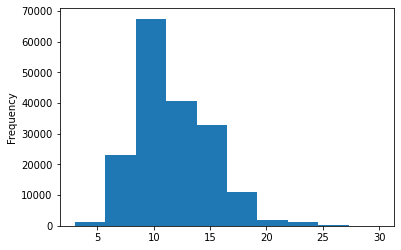

In [17]:
train_df.total_lines.plot.hist()

### get lists of sentences

In [18]:
train_sentences= train_df["text"].tolist()
val_sentences= val_df["text"].tolist()
test_sentences= test_df["text"].tolist()

In [19]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
train_sentences[1]

'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

### Make numeric Labels

In [21]:
# one hot Encoding of labels

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [22]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
import tensorflow as tf 
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [26]:
train_labels_encoded[:50]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 1, 0, 0, 3, 3, 2, 2, 2, 4, 4, 1,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 1, 0, 3, 2, 2, 2, 2, 4,
       4, 4, 4, 4, 1, 1])

In [27]:
num_classes  = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 : Baseline model

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [29]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

In [30]:
# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [31]:
baseline_score = model_0.score(val_sentences, val_labels_encoded)
baseline_score*100

72.1832384482987

In [32]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([4, 1, 3, ..., 4, 4, 1])

### Getting Helper Function

In [33]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-06 19:24:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-06 19:24:19 (100 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [34]:
from helper_functions import calculate_results

In [35]:
baseline_results = calculate_results(val_labels_encoded,
                                     baseline_pred)

In [36]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing the data for Deep Sequencing models

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [38]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [39]:
sent_lens[:5]

[49, 27, 15, 14, 35]

In [40]:
avg_sent_len = np.mean(sent_lens)
round(avg_sent_len)

26

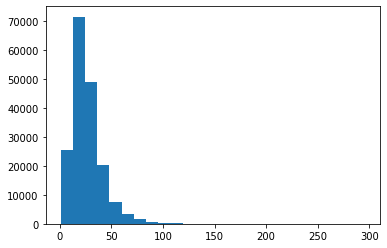

In [41]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=25);

In [42]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

### Text Vectorizer Layer

In [43]:
max_tokens = 68000

In [44]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [45]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [46]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [47]:
!nvidia-smi

Sat Nov  6 19:25:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |    361MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
import random
target_sentence = random.choice(train_sentences)
target_sentence, len(target_sentence), text_vectorizer([target_sentence])

('nontargeted metabolite profiling showed marked differences in fasting plasma after the intervention diets compared with the control diet .',
 138,
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[29710,  3260,  7028,   147,  2523,   102,     5,   662,   249,
            21,     2,    38,  1891,    34,     7,     2,    35,   376,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>)

In [53]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab), rct_20k_text_vocab[:5], rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [54]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Creating a Embedding Layer

In [55]:
# token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="Token_embedding")

In [59]:
target_sentence, text_vectorizer([target_sentence]), token_embed(text_vectorizer([target_sentence]))

('nontargeted metabolite profiling showed marked differences in fasting plasma after the intervention diets compared with the control diet .',
 <tf.Tensor: shape=(1, 55), dtype=int64, numpy=
 array([[29710,  3260,  7028,   147,  2523,   102,     5,   662,   249,
            21,     2,    38,  1891,    34,     7,     2,    35,   376,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]])>,
 <tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
 array([[[-0.04632505, -0.00849286, -0.02136329, ..., -0.0371047 ,
          -0.01266936,  0.04945724],
         [-0.0317003 ,  0.0264509 , -0.04580862, ..., -0.03569441,
          -0.00702908, -0.03934404],
         [ 0.04564724,  0.03033639,  0.00297061, ..., -0.03673331,
          -0.02937873,  0.0

In [61]:
token_embed(text_vectorizer([target_sentence])).shape

TensorShape([1, 55, 128])

### Better performances with tf datasets

In [62]:
train_datasets = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_datasets = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_datasets = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [63]:
train_datasets

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [64]:
train_datasets = train_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
valid_datasets = valid_datasets.batch(32).prefetch(tf.data.AUTOTUNE)
test_datasets = test_datasets.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
train_datasets

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D

In [78]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [79]:
model_1.summary()

Model: "model_1_Conv1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
Token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
__________________________________________

In [80]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_history = model_1.fit(train_datasets,
            epochs=5,
            steps_per_epoch = int(0.1 * len(train_datasets)),
            validation_data=valid_datasets,
            validation_steps = int(0.1 * len(valid_datasets)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 0.7558 - accuracy: 0.7223 - val_loss: 0.6528 - val_accuracy: 0.7583
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 0.5227 - accuracy: 0.8156 - val_loss: 0.6268 - val_accuracy: 0.7729
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 0.4807 - accuracy: 0.8345 - val_loss: 0.6013 - val_accuracy: 0.7786
Epoch 4/5
562/562 [==============================] - 3s 6ms/step - loss: 0.4645 - accuracy: 0.8391 - val_loss: 0.5917 - val_accuracy: 0.7869
Epoch 5/5
562/562 [==============================] - 3s 6ms/step - loss: 0.4638 - accuracy: 0.8392 - val_loss: 0.5764 - val_accuracy: 0.7979


In [81]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.5791 - accuracy: 0.7969


[0.579125165939331, 0.7969018816947937]

In [82]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.69018932874354,
 'f1': 0.7941930705282738,
 'precision': 0.7942508380529203,
 'recall': 0.7969018932874354}

In [83]:
# Model 1
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1d")

In [75]:
model_1_1_history = model_1.fit(train_datasets,
            epochs=5,
            validation_data=valid_datasets,
            )

Epoch 1/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.4379 - accuracy: 0.8423 - val_loss: 0.4893 - val_accuracy: 0.8199
Epoch 2/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.2829 - accuracy: 0.9055 - val_loss: 0.5470 - val_accuracy: 0.8091
Epoch 3/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.1518 - accuracy: 0.9546 - val_loss: 0.6625 - val_accuracy: 0.7946
Epoch 4/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.0765 - accuracy: 0.9793 - val_loss: 0.8179 - val_accuracy: 0.7887
Epoch 5/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.0432 - accuracy: 0.9885 - val_loss: 0.9767 - val_accuracy: 0.7882


In [76]:
model_1.evaluate(valid_datasets)

945/945 [==============================] - 3s 3ms/step - loss: 0.9767 - accuracy: 0.7882


[0.9767193794250488, 0.7882298231124878]

In [77]:
model_1_pred_probs = model_1.predict(valid_datasets)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.82298424467099,
 'f1': 0.7859937361495289,
 'precision': 0.7848601979841,
 'recall': 0.7882298424467099}